In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob
from astropy.io import fits
import pandas as pd

# set colors to be colorblind friendly
plt.style.use('seaborn-v0_8-colorblind')

filter_dir = "../data/filter_set/"
figs_dir = "../figs/poster/"

CII = 157.74 # [um]
OIIIa = 88.36 # [um]
OIIIb = 52.98 # [um]
OIa= 63.18 # [um]
# OIb = 145.53 # [um]
NIIa = 121.9 # [um]
NIIb = 205.18 # [um]
CO21 = 230.54 # [um]

def wav_to_z(wav, wav_line=CII):
    return wav / wav_line - 1

def z_to_wav(z, wav_line=CII):
    return (z + 1) * wav_line

Matplotlib is building the font cache; this may take a moment.


In [2]:
wav_to_z(157.74), wav_to_z(240), wav_to_z(420), z_to_wav(0.0), z_to_wav(1.0)

(0.0, 0.5214910612400152, 1.6626093571700267, 157.74, 315.48)

In [3]:
gals = pd.read_csv("../simstack3/viero2022/notebooks/Appendix/temp_A0.csv")
gals

,ALPHA_J2000,DELTA_J2000,lp_zBEST,lp_mass_med,ez_restU-V,ez_restV-J,restNUV-R,restR-J,lp_SFR_best,lp_sSFR_med,lp_type
0,150.753332,1.603333,1.2724,8.40210,0.272594,0.614739,1.54800,0.14217,-0.2891,-8.55800,0
1,150.774956,1.603397,2.8991,9.16265,0.051764,-0.343340,0.24773,-0.00466,0.8855,-8.32349,0
2,150.768257,1.603256,0.9599,8.70300,0.828829,0.200030,1.60135,0.23036,-0.8530,-8.88367,0
3,150.729759,1.603437,0.3600,6.85860,0.118297,-0.168686,0.59021,-0.08536,-1.7770,-8.45414,0
4,150.763360,1.603470,1.2045,9.19418,1.011478,0.973295,2.31736,0.56873,-0.4258,-8.96474,0
...,...,...,...,...,...,...,...,...,...,...,...
710047,149.846286,2.808246,2.0997,10.59901,1.047982,1.422760,0.84275,0.43796,2.2700,-8.57679,0
710048,149.456702,2.815315,0.3288,9.51572,0.858950,0.565846,1.85020,0.45436,0.4522,-9.08606,0
710049,149.844633,2.811531,3.0910,10.49146,0.408546,1.027004,2.57724,0.78532,1.7000,-8.50025,0
710050,149.593532,2.811659,0.3321,11.03385,2.025162,1.312841,5.96770,1.09755,-10.1400,-21.19872,0


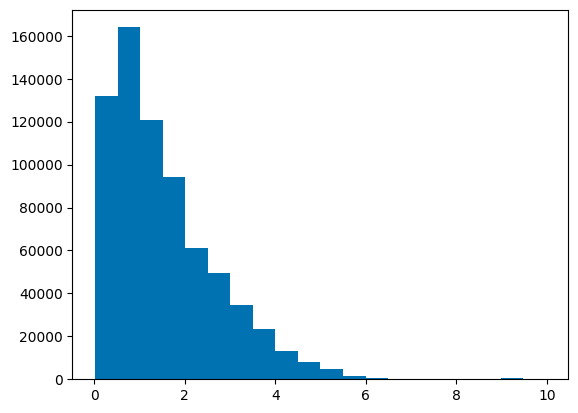

In [4]:
plt.figure()
plt.hist(gals["lp_zBEST"], bins=20)
plt.show()
plt.close()

In [5]:
mips24 = np.loadtxt(f'{filter_dir}/mips24.res', comments='#')
mips70 = np.loadtxt(f'{filter_dir}/mips70.res', comments='#')
mips160 = np.loadtxt(f'{filter_dir}/mips160.res', comments='#')

In [6]:
pacs100 = np.loadtxt(f'{filter_dir}/PACS_filter_100.txt')
pacs160 = np.loadtxt(f'{filter_dir}/PACS_filter_160.txt')
spire250 = np.loadtxt(f'{filter_dir}/SPIRE_filter_250.txt')
spire350 = np.loadtxt(f'{filter_dir}/SPIRE_filter_350.txt')
spire500 = np.loadtxt(f'{filter_dir}/SPIRE_filter_500.txt')

In [7]:
scuba850model = np.loadtxt(f'{filter_dir}/scubamodel850.txt', comments='#')[:, (0, -1)]
scuba850s8c = np.loadtxt(f'{filter_dir}/scuba850s8c.txt', skiprows=2)[:, (0, 1)]
scuba850s8d = np.loadtxt(f'{filter_dir}/scuba850s8d.txt', skiprows=2)[:, (0, 1)]

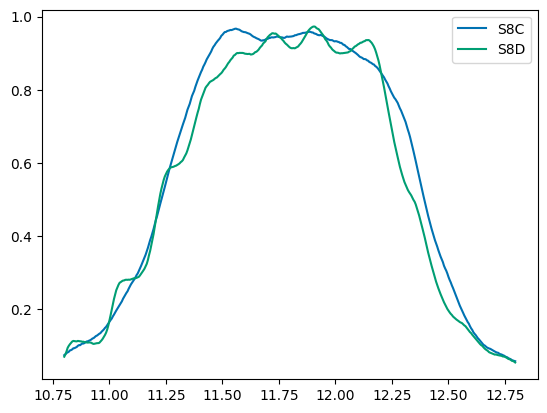

In [8]:
plt.figure()
# plt.plot(scuba850model[:, 0], scuba850model[:, 1], label='Model')
plt.plot(scuba850s8c[:, 0], scuba850s8c[:, 1], label='S8C')
plt.plot(scuba850s8d[:, 0], scuba850s8d[:, 1], label='S8D')
plt.legend()
plt.show()
plt.close()

In [9]:
scuba850 = np.median([scuba850s8c, scuba850s8d], axis=0)
# convert from cm-1 wavenumber to wavelength, in angstroms
scuba850[:, 0] = 1e8 / scuba850[:, 0]

In [10]:
filters = {
    r'MIPS $24~\mu m$': mips24,
    r'MIPS $70~\mu m$': mips70,
    r'MIPS $160~\mu m$': mips160,
    r'PACS $100~\mu m$': pacs100,
    r'PACS $160~\mu m$': pacs160,
    r'SPIRE $250~\mu m$': spire250,
    r'SPIRE $350~\mu m$': spire350,
    r'SPIRE $500~\mu m$': spire500,
    r'SCUBA $850~\mu m$': scuba850
}

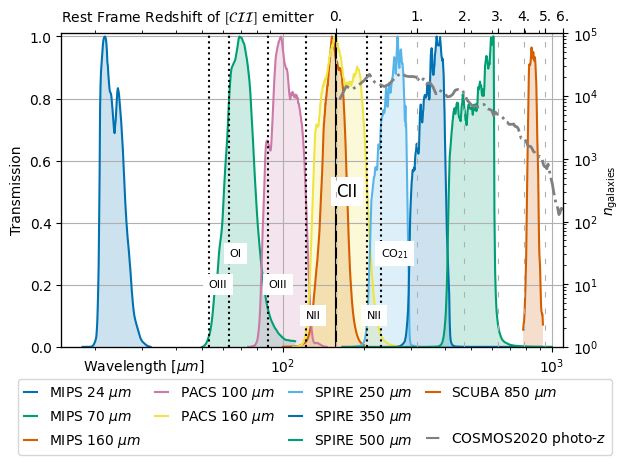

In [11]:
plt.figure()
for name, data in filters.items():
    wvs = data[:, 0] * 1e-4
    plt.plot(wvs, data[:, 1], label=name)
    plt.fill_between(wvs, 0, data[:, 1], alpha=0.2)
    if name in [r'PACS $160~\mu m$', r'SCUBA $850~\mu m$']:
        # hack to get the labels to show up in the right place
        plt.axhline(CII, label=" ", ls='none')

ax1 = plt.gca()

# add histogram of redshifts
z_hist, zvals = np.histogram(gals["lp_zBEST"], bins=100, range=(0, 6))
zvals = (zvals[1:] + zvals[:-1]) / 2
wv_vals = z_to_wav(zvals)
ax_y = ax1.twinx()
ax_y.plot(wv_vals, z_hist, color='gray', alpha=1, ls='-.', lw=2)
# hack to add to legend
ax1.plot([], [], color='gray', alpha=1, ls='-.', label=r'COSMOS2020 photo-$z$')
ax_y.set_ylabel(r'$n_\text{galaxies}$')
ax_y.set_yscale('log')
ax_y.set_ylim(1, 10 ** int(np.log10(z_hist.max()) + 1))

# add a second x-axis with redshift
ax2 = ax1.twiny()
ax1.set_xlim(1.5e1, 1.1e3)
ax2.set_xlim(ax1.get_xlim())
ax1.set_xscale('log')
ax2.set_xscale('log') 
z_ticks = np.arange(0, 6.1, 1)
wav_ticks = z_to_wav(z_ticks)
ax2.set_xticks(wav_ticks)
ax2.set_xticklabels([f'{z:.0f}.' for z in z_ticks])
ax2.set_xlabel(r'Rest Frame Redshift of $\mathcal{[CII]}$ emitter', labelpad=-9, loc='left')

ax1.grid()
ax1.set_xlabel(r'     Wavelength [$\mu m$]', labelpad=-13, loc='left')
ax1.set_ylabel('Transmission')
ax2.grid(linestyle=(0, (5, 10)))

for line, label, xpos in zip([OIIIa, OIIIb, OIa, NIIa, NIIb, CO21, CII], \
        ['OIII', 'OIII', 'OI', 'NII', 'NII', r'CO$_{21}$', 'CII'], \
        [0.2, 0.2, 0.3, 0.1, 0.1, 0.3, 0.5]):
    ls = '-' if label == 'CII' else ':'
    fontsize = 12 if label == 'CII' else 8
    ax1.axvline(line, color='k', linestyle=ls)
    ax1.text(line, xpos, label, rotation=0, va='center', ha='left', fontsize=fontsize,
            bbox=dict(facecolor='white', edgecolor='none', alpha=1))
ax1.axvline()

ax1.legend(fontsize=10, bbox_to_anchor=(-.1, -.08), loc='upper left', ncol=4, \
    mode=None, handlelength=1., columnspacing=1)
plt.ylim(0, 1.01)

plt.tight_layout()
plt.savefig(f'{figs_dir}/filter_curves.pdf', bbox_inches='tight', dpi=300)
# plt.savefig(f'{figs_dir}/filter_curves.eps', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [16]:
for name, data in filters.items():
    wvs = data[:, 0] * 1e-4
    trans = data[:, 1]
    redshifts = wav_to_z(wvs)
    mask = trans > 0.5
    print(name)
    print(redshifts[np.argwhere(mask)[0]], redshifts[np.argwhere(mask)[-1]])

MIPS $24~\mu m$
[-0.86797895] [-0.83645239]
MIPS $70~\mu m$
[-0.61609256] [-0.50122264]
MIPS $160~\mu m$
[-0.11985926] [0.09731774]
PACS $100~\mu m$
[-0.46018765] [-0.22942817]
PACS $160~\mu m$
[-0.18061367] [0.30562952]
SPIRE $250~\mu m$
[0.83435939] [0.36334322]
SPIRE $350~\mu m$
[1.55936459] [0.90433948]
SPIRE $500~\mu m$
[2.85148605] [1.63160898]
SCUBA $850~\mu m$
[4.64743581] [4.12469444]
